# qBraid Quantum Labs: IBM Devices with your own credentials

Authors: Sophy Shin, James Weaver, Brian Ingmanson

Updated by: Rohan Jain

This tutorial is about using Qiskit Runtime through qBraid Quantum Lab. The `Default` Environment supports most of the up-to-date versions of Qiskit, so the first step will be to bring your own credential from [IBM Quantum Platform](https://quantum.ibm.com/). 

If you do not already have a user account, get one at the [IBM Quantum login page](https://quantum.ibm.com/login). Your user account is associated with one or more [instances](https://docs.quantum.ibm.com/run/instances) (in the form hub / group / project) that give access to IBM Quantum services. Additionally, a unique token is assigned to each account, allowing for IBM Quantum access from Qiskit. The instructions in this section use our default instance. For instructions to choose a specific instance, see [Connect to an instance](https://docs.quantum.ibm.com/run/instances#connect-instance).

After logging in, at the top right, you can check the instances that you can use, and you can copy the API Token according to the instance at the right side of the banner by clicking the squared icon.

<img src="./img/ibm_api_token.png" />

If you are using `Open Plan` you can run your quantum circuits on IBM quantum systems for free (up to 10 minutes quantum time per month). See [IBM Quantum access plans](https://www.ibm.com/quantum/pricing) for details.

## 1. Using Qiskit Runtime Provider

Now you can start using IBM Quantum Backends by calling QiskitRuntimeService with your API Credential replace `<MY_IBM_QUANTUM_TOKEN>` by your own token:

In [1]:
# set up service by using open plan instance. you can delete or modify to use another instance

from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(
    channel="ibm_quantum", instance="ibm-q/open/main", token="<MY_IBM_QUANTUM_TOKEN>"
)

To view the backends you have access to, you can use the `QiskitRuntimeService.backends()` method. Let's check your backend list:

In [2]:
service.backends()

[<IBMBackend('ibm_brisbane')>,
 <IBMBackend('ibm_kyoto')>,
 <IBMBackend('ibm_osaka')>,
 <IBMBackend('ibm_sherbrooke')>]

The `QiskitRuntimeService.backend()` method (note that this is singular: backend) takes the name of the backend as the input parameter and returns an IBMBackend instance representing that particular backend. The following code will select `ibm_kyoto` and save it as a `backend_sim`

In [3]:
backend_sim = service.backend("ibm_kyoto")

You can also filter the available backends by their properties. For more general filters, you can make advanced functions using a lambda function. Refer to the [API documentation](https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.QiskitRuntimeService#backends) for more details.

As shown here, we will filter least busy real backend and save it to `backend`.

In [4]:
backend = service.least_busy(simulator=False, operational=True)
backend

<IBMBackend('ibm_kyoto')>

### Create a toy circuit

Now, let's create a simple bell state using qiskit;

In [5]:
from qiskit import QuantumCircuit

circ = QuantumCircuit(2)
circ.h(0)
circ.cx(0, 1)
circ.measure_all()

circ.draw()

┌───┐      ░ ┌─┐   
   q_0: ┤ H ├──■───░─┤M├───
        └───┘┌─┴─┐ ░ └╥┘┌─┐
   q_1: ─────┤ X ├─░──╫─┤M├
             └───┘ ░  ║ └╥┘
meas: 2/══════════════╩══╩═
                      0  1

### Execute using a quantum primitive function

Quantum computers can produce random results, so you'll often want to collect a sample of the outputs by running the circuit many times. You can use the `Sampler` class to get measured data from a quantum Computer. `Sampler` is one of our two [primitives](https://docs.quantum.ibm.com/run/primitives-get-started); the other is `Estimator`, which estimates the value of observable. We will be using `Estimator` in this example.

In [6]:
from qiskit_ibm_runtime import Estimator
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager


# Create an Estimator object
estimator = Estimator(backend)

# Create observable
n_qubits = 2
observable = SparsePauliOp("Z" * n_qubits)

# The circuit and observable need to be transformed to only use supported instructions (instruction set architecture(ISA)).
pm = generate_preset_pass_manager(optimization_level = 1, backend = backend)
isa_circuit = pm.run(circ)
isa_observable = observable.apply_layout(isa_circuit.layout)

# Submit the circuit to Sampler
job = estimator.run(isa_circuit, isa_observable)

/var/folders/bp/ynvhmy5n0r35yx8vh_lgfnwm0000gp/T/ipykernel_8318/1131823703.py:7: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend)


You can print the job's id and status by using the job instance. Run below cell to check both.

In [7]:
jobid = job.job_id()
print(f">>> Job ID: {job.job_id()}")
print(f">>> Job Status: {job.status()}")

>>> Job ID: csczppax35wg00811z00
>>> Job Status: JobStatus.QUEUED


### Retrieve job results at a later time

You can call service.job(\<job\how_toID>) to retrieve a job you previously submitted. If you don’t have the job ID, or if you want to retrieve multiple jobs at once; including jobs from retired systems, call service.jobs() with optional filters instead. See [QiskitRuntimeService.jobs](https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.QiskitRuntimeService#jobs) for details.

As shown here, we will retrieve the job result and save it as a `retrieve_job` to see the result.

In [15]:
retrieve_job = service.job(jobid)
result = retrieve_job.result()

Now we will plot the results. 

As estimator returns expected value of measurement, we just print out what it is.

In [18]:
print(job.result().values[0])

1.3944620971402633


## 2. Using qBraid-SDK

You can also use qBraid-SDK to submit your IBM job and check job status. The following show how to do that.

First, check the qBraid version.

In [9]:
import qbraid

qbraid.__version__

'0.7.0.dev20240516020308'

Now import essential libraries and save your ibm api token as an environment variable. Then, set-up your `QiskitProvider` with that token.

In [10]:
from qbraid.runtime.qiskit import QiskitRuntimeProvider
import os

os.environ["QISKIT_IBM_TOKEN"] = "<MY_IBM_QUANTUM_TOKEN>"
ibmq_token = os.getenv("QISKIT_IBM_TOKEN")
provider = QiskitRuntimeProvider(ibmq_token)

You can also see the device list, accessible with your token.

In [11]:
provider.get_devices()

[<qbraid.runtime.qiskit.device.QiskitBackend('ibm_brisbane')>,
 <qbraid.runtime.qiskit.device.QiskitBackend('ibm_kyoto')>,
 <qbraid.runtime.qiskit.device.QiskitBackend('ibm_osaka')>,
 <qbraid.runtime.qiskit.device.QiskitBackend('ibm_sherbrooke')>]

You can quickly find the least busy device by using `ibm_least_busy_gpu()`, or use `get_devices()` to see all the available devices.

In [12]:
# ibm_device = provider.ibm_least_busy_qpu() # return least busy backend of provider
# ibm_device = provider.get_devices() # return list of all backends
ibm_device = provider.get_device("ibm_kyoto")  # return backend by name

To send the quantum circuit to the backend and check the job status in the right sidebar of qBraid Quantum lab, we just run the device.

In [13]:
# Must have IBM credential to submit jobs using premium backends
qbraid_ibm_job = ibm_device.run(circ, shots=200)

Also, you can check your job status by using `status()`.

In [14]:
qbraid_ibm_job.status()

<JobStatus.QUEUED: 'job is queued'>

After the job has completed, we’ll gather the result, print the measurement counts, and plot a histogram of the count by using `qbraid.visualization.plot_histogram`

In [19]:
ibm_result = qbraid_ibm_job.result()

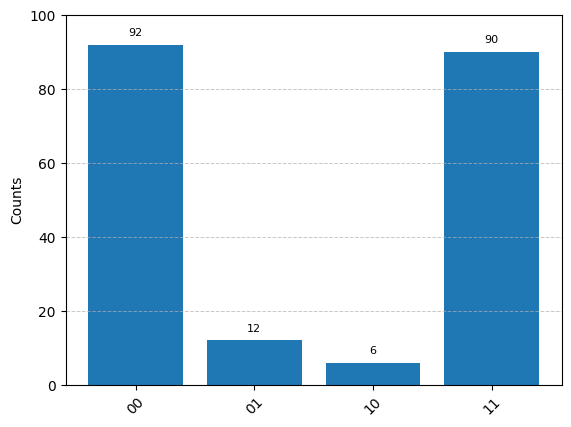

In [21]:
from qbraid.visualization import plot_histogram, plot_distribution

plot_histogram(ibm_result.measurement_counts())

Also, you can plot a histogram of a probability with `plot_distribution`.

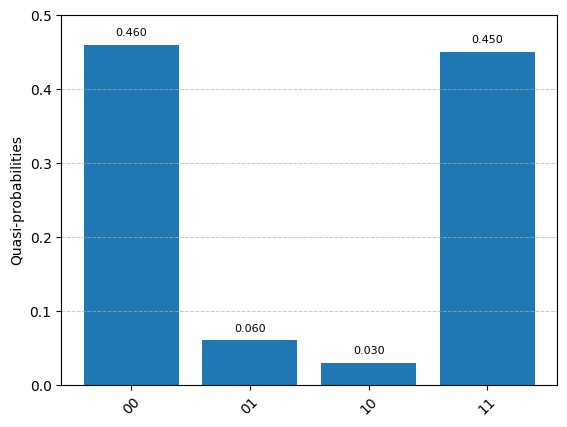

In [22]:
plot_distribution(ibm_result.measurement_counts())